In [1]:
import pandas as pd
import numpy as np
import holidays
import warnings
import matplotlib.pyplot as plt
from math import sqrt
import matplotlib.dates as mdates
import pytz
import datetime
warnings.filterwarnings('ignore')

# 1. average model

## 1.1. load data

In [2]:
df = pd.read_csv('data\Gallup Historical Hourly Load-2018-2020.csv')
df

,Year,Month,Day,period,Total Gross Load,BTM WAPA,Total Net Load Serve,Unnamed: 7,Unnamed: 8,Unnamed: 9,Source,Unnamed: 11
0,2018,1,1,1,23.86,2.34,22,NaN,NaN,Total Gross Load,Gallup Historical,NaN
1,2018,1,1,2,23.46,2.34,21,NaN,NaN,BTM WAPA,Hourly estimated based on monthly/annual energy,NaN
2,2018,1,1,3,23.28,2.34,21,NaN,NaN,NaN,NaN,NaN
3,2018,1,1,4,23.07,2.34,21,NaN,NaN,Current PLEXOS Forecast Gross Flat,191,GWh/year
4,2018,1,1,5,23.44,2.34,21,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
26299,2020,12,31,20,28.39,2.34,26,NaN,NaN,NaN,NaN,NaN
26300,2020,12,31,21,27.43,2.34,25,NaN,NaN,NaN,NaN,NaN
26301,2020,12,31,22,26.25,2.34,24,NaN,NaN,NaN,NaN,NaN
26302,2020,12,31,23,25.18,2.34,23,NaN,NaN,NaN,NaN,NaN


In [3]:
df.columns

Index(['Year', 'Month ', 'Day', 'period', 'Total Gross Load', 'BTM WAPA',
       'Total Net Load Serve', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9',
       'Source', 'Unnamed: 11'],
      dtype='object')

In [4]:
df.rename(columns={'Year':'year', 'Month ':'month', 'Day':'day', 'period':'time', 'Total Gross Load':'gross_load'}, inplace=True)
df.drop(columns=['BTM WAPA','Total Net Load Serve', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9','Source', 'Unnamed: 11'], inplace=True)

In [5]:
df

,year,month,day,time,gross_load
0,2018,1,1,1,23.86
1,2018,1,1,2,23.46
2,2018,1,1,3,23.28
3,2018,1,1,4,23.07
4,2018,1,1,5,23.44
...,...,...,...,...,...
26299,2020,12,31,20,28.39
26300,2020,12,31,21,27.43
26301,2020,12,31,22,26.25
26302,2020,12,31,23,25.18


In [6]:
def time_convert(period):
    hour = (period - 1) % 24  # Convert period to 0-23 hour range
    return f'{hour:02d}:00:00'
# Create datetime column
df['hour_begins'] = pd.to_datetime(df[['year', 'month', 'day']].astype(str).agg('-'.join, axis=1) + ' ' + df['time'].apply(time_convert))

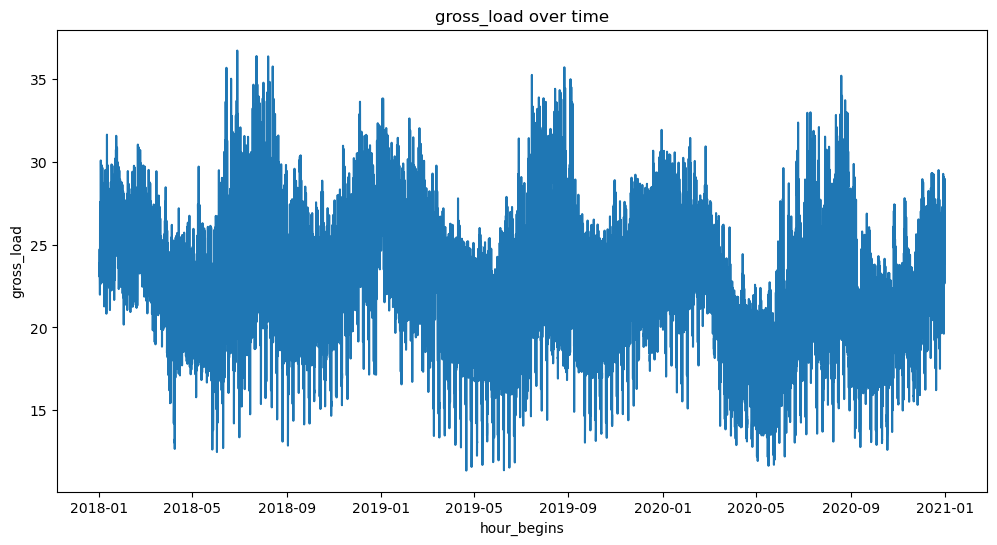

In [7]:
import matplotlib.pyplot as plt

# basic plots for actual_gross_load with x being hour_begins
plt.figure(figsize=(12, 6))
plt.plot(df['hour_begins'], df['gross_load'])
plt.title('gross_load over time')
plt.xlabel('hour_begins')
plt.ylabel('gross_load')
plt.show()

In [8]:

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

# Apply the season function to the DataFrame
df['season'] = df['month'].apply(get_season)

Winter - Lower bound: 17.79, Upper bound: 31.45
Spring - Lower bound: 13.02, Upper bound: 27.22
Summer - Lower bound: 14.43, Upper bound: 33.43
Fall - Lower bound: 14.07, Upper bound: 29.61


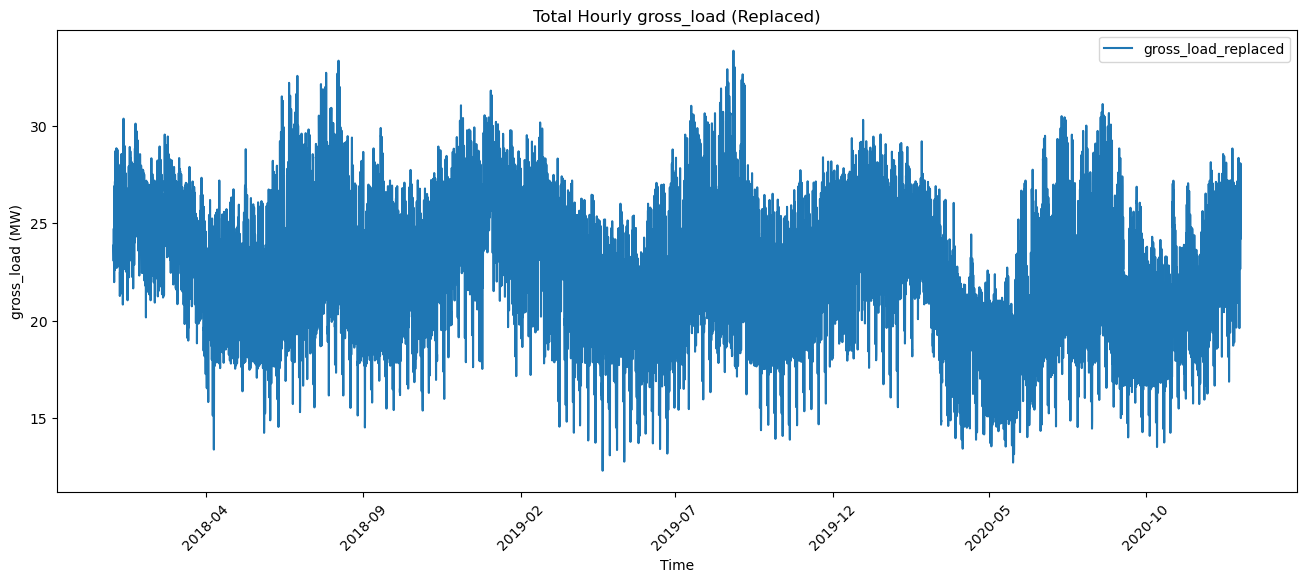

In [9]:
# Function to replace outliers within each season
def replace_outliers_with_avg_seasonal(df):
    df['gross_load_replaced'] = df['gross_load']
    for season in df['season'].unique():
        season_data = df[df['season'] == season]['gross_load']
        lower_bound = season_data.quantile(0.01)
        upper_bound = season_data.quantile(0.99)
        print(f'{season} - Lower bound: {lower_bound:.2f}, Upper bound: {upper_bound:.2f}')
        
        outliers = (df['gross_load'] < lower_bound) | (df['gross_load'] > upper_bound) | (df['gross_load'] == 0) | (df['gross_load'] == np.nan) 
        
        # Remove continuous zeros or NaNs at the end
        while pd.isna(df.iloc[-1]['gross_load_replaced']) or df.iloc[-1]['gross_load_replaced'] == 0:
            df = df.iloc[:-1]

        for idx in df[outliers].index:
            if idx == 0 or idx == len(df) - 1:
                # directly drop the first and last value
                df.at[idx, 'gross_load_replaced'] = np.nan
                continue
            # Handle edge cases where previous or next value might be NaN or zero
            prev_idx = idx - 1
            next_idx = idx + 1
            while prev_idx >= 0 and (pd.isna(df.iloc[prev_idx]['gross_load_replaced']) or df.iloc[prev_idx]['gross_load_replaced'] == 0):
                prev_idx -= 1
            while next_idx < len(df) and (pd.isna(df.iloc[next_idx]['gross_load_replaced']) or df.iloc[next_idx]['gross_load_replaced'] == 0):
                next_idx += 1
            
            if prev_idx >= 0 and next_idx < len(df):
                prev_val = df.iloc[prev_idx]['gross_load_replaced']
                next_val = df.iloc[next_idx]['gross_load_replaced']
                df.at[idx, 'gross_load_replaced'] = (prev_val + next_val) / 2
            elif prev_idx >= 0:
                df.at[idx, 'gross_load_replaced'] = df.iloc[prev_idx]['gross_load_replaced']
            elif next_idx < len(df):
                df.at[idx, 'gross_load_replaced'] = df.iloc[next_idx]['gross_load_replaced']

    return df

df = replace_outliers_with_avg_seasonal(df)

plt.figure(figsize=(16, 6))
plt.plot(df['hour_begins'], df['gross_load_replaced'], label='gross_load_replaced')
plt.xlabel('Time')
plt.ylabel('gross_load (MW)')
plt.title('Total Hourly gross_load (Replaced)')
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

plt.show()

In [10]:
df

,year,month,day,time,gross_load,hour_begins,season,gross_load_replaced
0,2018,1,1,1,23.86,2018-01-01 00:00:00,Winter,23.86
1,2018,1,1,2,23.46,2018-01-01 01:00:00,Winter,23.46
2,2018,1,1,3,23.28,2018-01-01 02:00:00,Winter,23.28
3,2018,1,1,4,23.07,2018-01-01 03:00:00,Winter,23.07
4,2018,1,1,5,23.44,2018-01-01 04:00:00,Winter,23.44
...,...,...,...,...,...,...,...,...
26299,2020,12,31,20,28.39,2020-12-31 19:00:00,Winter,27.75
26300,2020,12,31,21,27.43,2020-12-31 20:00:00,Winter,27.00
26301,2020,12,31,22,26.25,2020-12-31 21:00:00,Winter,26.25
26302,2020,12,31,23,25.18,2020-12-31 22:00:00,Winter,25.18



## 1.2.feature engineering

In [11]:
# calculate the daily average load
df['date'] = df['hour_begins'].dt.date
daily_gross_load = df.groupby('date')['gross_load_replaced'].mean().reset_index()
daily_high = df.groupby('date')['gross_load_replaced'].max().reset_index()
daily_low = df.groupby('date')['gross_load_replaced'].min().reset_index()
daily_std = df.groupby('date')['gross_load_replaced'].std().reset_index()

daily_gross_load['daily_high'] = daily_high['gross_load_replaced']
daily_gross_load['daily_low'] = daily_low['gross_load_replaced']
daily_gross_load['daily_std'] = daily_std['gross_load_replaced']
daily_gross_load.rename(columns = {'gross_load_replaced': 'daily_avg'}, inplace = True)

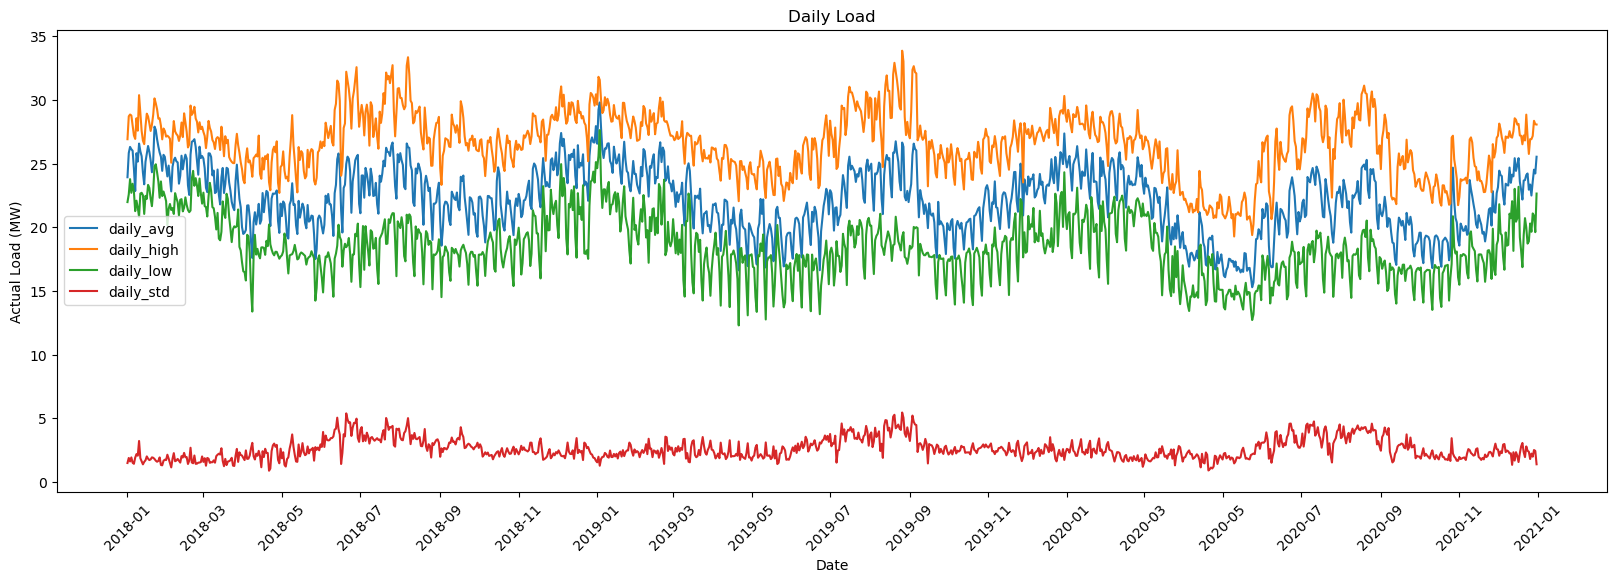

In [12]:
import matplotlib.dates as mdates
# plot the daily average, min, max, std
plt.figure(figsize=(20, 6))
plt.plot(daily_gross_load['date'], daily_gross_load['daily_avg'], label='daily_avg')
plt.plot(daily_gross_load['date'], daily_gross_load['daily_high'], label='daily_high')
plt.plot(daily_gross_load['date'], daily_gross_load['daily_low'], label='daily_low')
plt.plot(daily_gross_load['date'], daily_gross_load['daily_std'], label='daily_std')
plt.xlabel('Date')
plt.ylabel('Actual Load (MW)')
plt.title('Daily Load')
plt.legend()

# Set date format on x-axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # set to show every 3 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)
plt.show()

In [13]:
daily_gross_load

,date,daily_avg,daily_high,daily_low,daily_std
0,2018-01-01,23.930885,26.917500,21.98,1.497397
1,2018-01-02,25.834857,28.714375,22.59,1.892179
2,2018-01-03,26.312318,28.855000,23.78,1.617253
3,2018-01-04,26.126016,28.778750,22.71,1.936380
4,2018-01-05,26.012734,28.022500,23.42,1.514981
...,...,...,...,...,...
1091,2020-12-27,22.495833,26.920000,19.65,2.235916
1092,2020-12-28,23.585208,27.170000,21.09,1.992687
1093,2020-12-29,24.526354,28.360000,20.91,2.513542
1094,2020-12-30,24.223125,28.090000,19.62,2.447265


In [14]:
# day of the week, month, year, season vairables
daily_gross_load['date'] = pd.to_datetime(daily_gross_load['date'])
daily_gross_load['day'] = daily_gross_load['date'].dt.day
daily_gross_load['day_of_week'] = daily_gross_load['date'].dt.dayofweek
daily_gross_load['month'] = daily_gross_load['date'].dt.month
daily_gross_load['year'] = daily_gross_load['date'].dt.year
daily_gross_load['seasons'] = (daily_gross_load['month']%12 + 3)//3
seasons = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
daily_gross_load['seasons'] = daily_gross_load['seasons'].map(seasons)

In [15]:
daily_gross_load['month_sin'] = np.sin((daily_gross_load['month'] - 1) * (2. * np.pi / 12))
daily_gross_load['month_cos'] = np.cos((daily_gross_load['month'] - 1) * (2. * np.pi / 12))
daily_gross_load['dow_sin'] = np.sin(daily_gross_load['day_of_week'] * (2. * np.pi / 7))
daily_gross_load['dow_cos'] = np.cos(daily_gross_load['day_of_week'] * (2. * np.pi / 7))

In [16]:
# holiday - 0/1 binary
us_holidays = holidays.US()
daily_gross_load['holiday'] = daily_gross_load['date'].apply(lambda x: 1 if x in us_holidays else 0)

In [17]:
daily_gross_load.drop(columns=['daily_high','daily_low', 'daily_std'], inplace=True)
daily_gross_load.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         1096 non-null   datetime64[ns]
 1   daily_avg    1096 non-null   float64       
 2   day          1096 non-null   int32         
 3   day_of_week  1096 non-null   int32         
 4   month        1096 non-null   int32         
 5   year         1096 non-null   int32         
 6   seasons      1096 non-null   object        
 7   month_sin    1096 non-null   float64       
 8   month_cos    1096 non-null   float64       
 9   dow_sin      1096 non-null   float64       
 10  dow_cos      1096 non-null   float64       
 11  holiday      1096 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int32(4), int64(1), object(1)
memory usage: 85.8+ KB


In [18]:
# print out the numerical and categorical features
numerical_features = daily_gross_load.select_dtypes(include=['float64']).columns.tolist()
categorical_features = daily_gross_load.select_dtypes(include=['datetime64[ns]', 'object', 'bool','int32','int64']).columns.tolist()
target = 'daily_avg'
numerical_features.remove(target)
print(f'Target variable: {target}')
print(f'Numerical features: {numerical_features}')
print(f'Categorical features: {categorical_features}')

# put categorical features first, numerical features last
daily_gross_load = daily_gross_load[categorical_features + numerical_features + [target]]
daily_gross_load

Target variable: daily_avg
Numerical features: ['month_sin', 'month_cos', 'dow_sin', 'dow_cos']
Categorical features: ['date', 'day', 'day_of_week', 'month', 'year', 'seasons', 'holiday']


,date,day,day_of_week,month,year,seasons,holiday,month_sin,month_cos,dow_sin,dow_cos,daily_avg
0,2018-01-01,1,0,1,2018,Winter,1,0.0,1.000000,0.000000,1.000000,23.930885
1,2018-01-02,2,1,1,2018,Winter,0,0.0,1.000000,0.781831,0.623490,25.834857
2,2018-01-03,3,2,1,2018,Winter,0,0.0,1.000000,0.974928,-0.222521,26.312318
3,2018-01-04,4,3,1,2018,Winter,0,0.0,1.000000,0.433884,-0.900969,26.126016
4,2018-01-05,5,4,1,2018,Winter,0,0.0,1.000000,-0.433884,-0.900969,26.012734
...,...,...,...,...,...,...,...,...,...,...,...,...
1091,2020-12-27,27,6,12,2020,Winter,0,-0.5,0.866025,-0.781831,0.623490,22.495833
1092,2020-12-28,28,0,12,2020,Winter,0,-0.5,0.866025,0.000000,1.000000,23.585208
1093,2020-12-29,29,1,12,2020,Winter,0,-0.5,0.866025,0.781831,0.623490,24.526354
1094,2020-12-30,30,2,12,2020,Winter,0,-0.5,0.866025,0.974928,-0.222521,24.223125


In [19]:
daily_gross_load.columns

Index(['date', 'day', 'day_of_week', 'month', 'year', 'seasons', 'holiday',
       'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'daily_avg'],
      dtype='object')

##  1.3. scaling and encoding

In [20]:
# encoding the categorical features - season only at the second column of values
daily_gross_load = pd.get_dummies(daily_gross_load, columns=['seasons'], drop_first=True) # at the last 3 columns
# Convert boolean columns to integers
for col in daily_gross_load.columns:
    if daily_gross_load[col].dtype == 'bool':
        daily_gross_load[col] = daily_gross_load[col].astype(int)
# place the target variable at the last column
daily_gross_load = daily_gross_load[[c for c in daily_gross_load if c not in ['daily_avg']] + ['daily_avg']]

In [21]:
daily_gross_load

,date,day,day_of_week,month,year,holiday,month_sin,month_cos,dow_sin,dow_cos,seasons_Spring,seasons_Summer,seasons_Winter,daily_avg
0,2018-01-01,1,0,1,2018,1,0.0,1.000000,0.000000,1.000000,0,0,1,23.930885
1,2018-01-02,2,1,1,2018,0,0.0,1.000000,0.781831,0.623490,0,0,1,25.834857
2,2018-01-03,3,2,1,2018,0,0.0,1.000000,0.974928,-0.222521,0,0,1,26.312318
3,2018-01-04,4,3,1,2018,0,0.0,1.000000,0.433884,-0.900969,0,0,1,26.126016
4,2018-01-05,5,4,1,2018,0,0.0,1.000000,-0.433884,-0.900969,0,0,1,26.012734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,2020-12-27,27,6,12,2020,0,-0.5,0.866025,-0.781831,0.623490,0,0,1,22.495833
1092,2020-12-28,28,0,12,2020,0,-0.5,0.866025,0.000000,1.000000,0,0,1,23.585208
1093,2020-12-29,29,1,12,2020,0,-0.5,0.866025,0.781831,0.623490,0,0,1,24.526354
1094,2020-12-30,30,2,12,2020,0,-0.5,0.866025,0.974928,-0.222521,0,0,1,24.223125


In [22]:
# scaling the columns except for the 1 column
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
daily_gross_load.iloc[:, 1:] = scaler.fit_transform(daily_gross_load.iloc[:, 1:])
daily_gross_load

,date,day,day_of_week,month,year,holiday,month_sin,month_cos,dow_sin,dow_cos,seasons_Spring,seasons_Summer,seasons_Winter,daily_avg
0,2018-01-01,0.000000,0.000000,0.0,0.0,1,0.50,1.000000,0.500000,1.000000e+00,0,0,1,0.595353
1,2018-01-02,0.033333,0.166667,0.0,0.0,0,0.50,1.000000,0.900969,8.019377e-01,0,0,1,0.726619
2,2018-01-03,0.066667,0.333333,0.0,0.0,0,0.50,1.000000,1.000000,3.568959e-01,0,0,1,0.759537
3,2018-01-04,0.100000,0.500000,0.0,0.0,0,0.50,1.000000,0.722521,5.551115e-17,0,0,1,0.746693
4,2018-01-05,0.133333,0.666667,0.0,0.0,0,0.50,1.000000,0.277479,0.000000e+00,0,0,1,0.738883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,2020-12-27,0.866667,1.000000,1.0,1.0,0,0.25,0.933013,0.099031,8.019377e-01,0,0,1,0.496415
1092,2020-12-28,0.900000,0.000000,1.0,1.0,0,0.25,0.933013,0.500000,1.000000e+00,0,0,1,0.571520
1093,2020-12-29,0.933333,0.166667,1.0,1.0,0,0.25,0.933013,0.900969,8.019377e-01,0,0,1,0.636406
1094,2020-12-30,0.966667,0.333333,1.0,1.0,0,0.25,0.933013,1.000000,3.568959e-01,0,0,1,0.615501


In [23]:
# save the values of column gross_load_replaced, drop it and the attach at the last column 
gross_load_replaced = daily_gross_load['daily_avg']
daily_gross_load.drop(columns='daily_avg', inplace=True)
daily_gross_load['daily_avg'] = gross_load_replaced
daily_gross_load

,date,day,day_of_week,month,year,holiday,month_sin,month_cos,dow_sin,dow_cos,seasons_Spring,seasons_Summer,seasons_Winter,daily_avg
0,2018-01-01,0.000000,0.000000,0.0,0.0,1,0.50,1.000000,0.500000,1.000000e+00,0,0,1,0.595353
1,2018-01-02,0.033333,0.166667,0.0,0.0,0,0.50,1.000000,0.900969,8.019377e-01,0,0,1,0.726619
2,2018-01-03,0.066667,0.333333,0.0,0.0,0,0.50,1.000000,1.000000,3.568959e-01,0,0,1,0.759537
3,2018-01-04,0.100000,0.500000,0.0,0.0,0,0.50,1.000000,0.722521,5.551115e-17,0,0,1,0.746693
4,2018-01-05,0.133333,0.666667,0.0,0.0,0,0.50,1.000000,0.277479,0.000000e+00,0,0,1,0.738883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,2020-12-27,0.866667,1.000000,1.0,1.0,0,0.25,0.933013,0.099031,8.019377e-01,0,0,1,0.496415
1092,2020-12-28,0.900000,0.000000,1.0,1.0,0,0.25,0.933013,0.500000,1.000000e+00,0,0,1,0.571520
1093,2020-12-29,0.933333,0.166667,1.0,1.0,0,0.25,0.933013,0.900969,8.019377e-01,0,0,1,0.636406
1094,2020-12-30,0.966667,0.333333,1.0,1.0,0,0.25,0.933013,1.000000,3.568959e-01,0,0,1,0.615501


In [24]:
daily_gross_load = daily_gross_load.dropna()
daily_gross_load.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            1096 non-null   datetime64[ns]
 1   day             1096 non-null   float64       
 2   day_of_week     1096 non-null   float64       
 3   month           1096 non-null   float64       
 4   year            1096 non-null   float64       
 5   holiday         1096 non-null   int64         
 6   month_sin       1096 non-null   float64       
 7   month_cos       1096 non-null   float64       
 8   dow_sin         1096 non-null   float64       
 9   dow_cos         1096 non-null   float64       
 10  seasons_Spring  1096 non-null   int32         
 11  seasons_Summer  1096 non-null   int32         
 12  seasons_Winter  1096 non-null   int32         
 13  daily_avg       1096 non-null   float64       
dtypes: datetime64[ns](1), float64(9), int32(3), int64(1)
mem

## 1.4. dividing the data into training and testing

In [25]:
years_of_data = len(daily_gross_load) / 365
print(f'Total years of data: {years_of_data}')
# total number of days for training and testing
print(f'Total number of days for training: {daily_gross_load.shape[0]}')

Total years of data: 3.0027397260273974
Total number of days for training: 1096


In [26]:
daily_gross_load = daily_gross_load.sort_values(by='date')
values = daily_gross_load.drop(columns='date').values
dates = daily_gross_load['date']

# out of sample data: total length multiplies 0.3
train_days = int(values.shape[0] * 0.7)
# in sample data: the rest of the data
train = values[:train_days, :]
train_timestamps = dates[:train_days]
# print(f'start date of in sample data: {train["date"].min()}')
# print(f'end date of in sample data: {train["date"].max()}')
# print(f'length of in sample data: {train.
# shape[0]}\n')

print(f'min: {train_timestamps.min()}')
print(f'max: {train_timestamps.max()}')
print(f'length of in sample data: {train.shape[0]}\n')

test = values[train_days:, : ]
test_timestamps = dates[train_days:]
# print(f'start date of out of sample data: {test["date"].min()}')
# print(f'end date of out of sample data: {test["date"].max()}')
# print(f'length of out of sample data: {test.shape[0]}\n')

print(f'min: {test_timestamps.min()}')
print(f'max: {test_timestamps.max()}')
print(f'length of out of sample data: {test.shape[0]}')

min: 2018-01-01 00:00:00
max: 2020-02-06 00:00:00
length of in sample data: 767

min: 2020-02-07 00:00:00
max: 2020-12-31 00:00:00
length of out of sample data: 329


In [27]:
# dividing the data into x and y
# x: All columns except the last,  y: The last column
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(767, 1, 12) (767,) (329, 1, 12) (329,)


## 1.5. fitting the model

In [60]:
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
# design network

# Define the model
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(1, kernel_regularizer=l2(0.01)))

# Set the initial learning rate to a lower value
initial_learning_rate = 0.003
optimizer = Adam(learning_rate=initial_learning_rate)
model.compile(loss='mae', optimizer=optimizer, metrics=['mae', 'mse', 'mape'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=1e-6)

# Fit the network
history = model.fit(train_X, train_y, epochs=300, batch_size=50, validation_data=(test_X, test_y),
                    verbose=2, shuffle=False,callbacks=[early_stopping, reduce_lr])

Epoch 1/300
16/16 - 1s - 55ms/step - loss: 0.3070 - mae: 0.2868 - mape: 56.8655 - mse: 0.1247 - val_loss: 0.2537 - val_mae: 0.2333 - val_mape: 2024501.7500 - val_mse: 0.0780 - learning_rate: 0.0030
Epoch 2/300
16/16 - 0s - 2ms/step - loss: 0.1739 - mae: 0.1539 - mape: 41.0032 - mse: 0.0377 - val_loss: 0.2002 - val_mae: 0.1819 - val_mape: 1668937.0000 - val_mse: 0.0491 - learning_rate: 0.0030
Epoch 3/300
16/16 - 0s - 2ms/step - loss: 0.1520 - mae: 0.1344 - mape: 30.9721 - mse: 0.0272 - val_loss: 0.1603 - val_mae: 0.1433 - val_mape: 1365105.0000 - val_mse: 0.0307 - learning_rate: 0.0030
Epoch 4/300
16/16 - 0s - 2ms/step - loss: 0.1408 - mae: 0.1238 - mape: 29.7577 - mse: 0.0235 - val_loss: 0.1489 - val_mae: 0.1324 - val_mape: 1214637.6250 - val_mse: 0.0260 - learning_rate: 0.0030
Epoch 5/300
16/16 - 0s - 4ms/step - loss: 0.1299 - mae: 0.1137 - mape: 26.5200 - mse: 0.0204 - val_loss: 0.1331 - val_mae: 0.1172 - val_mape: 1049644.7500 - val_mse: 0.0205 - learning_rate: 0.0030
Epoch 6/300
16

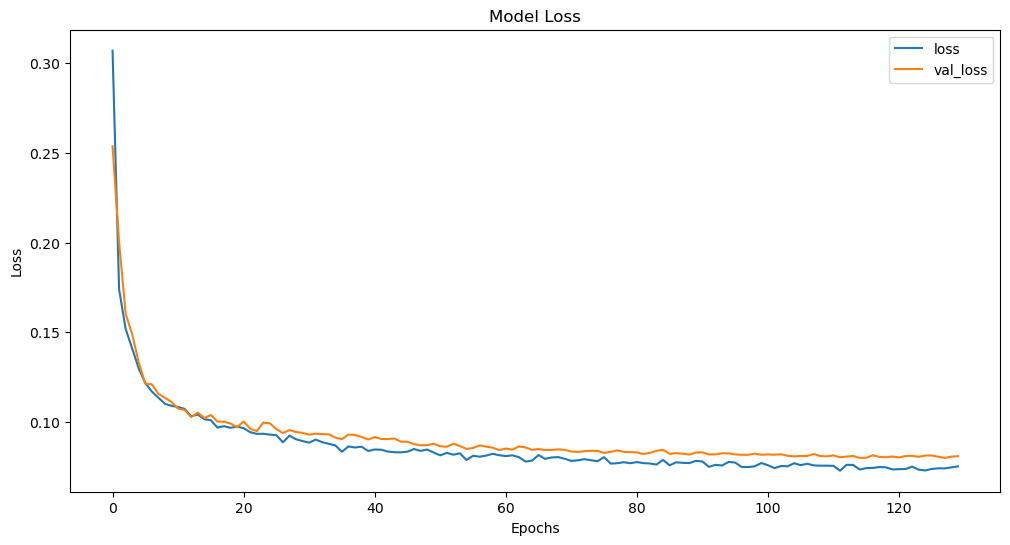

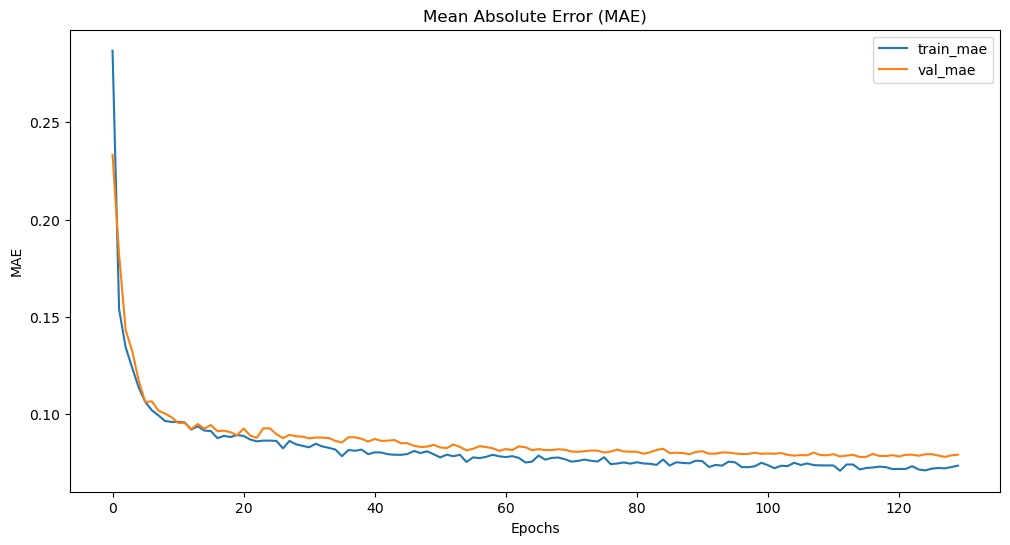

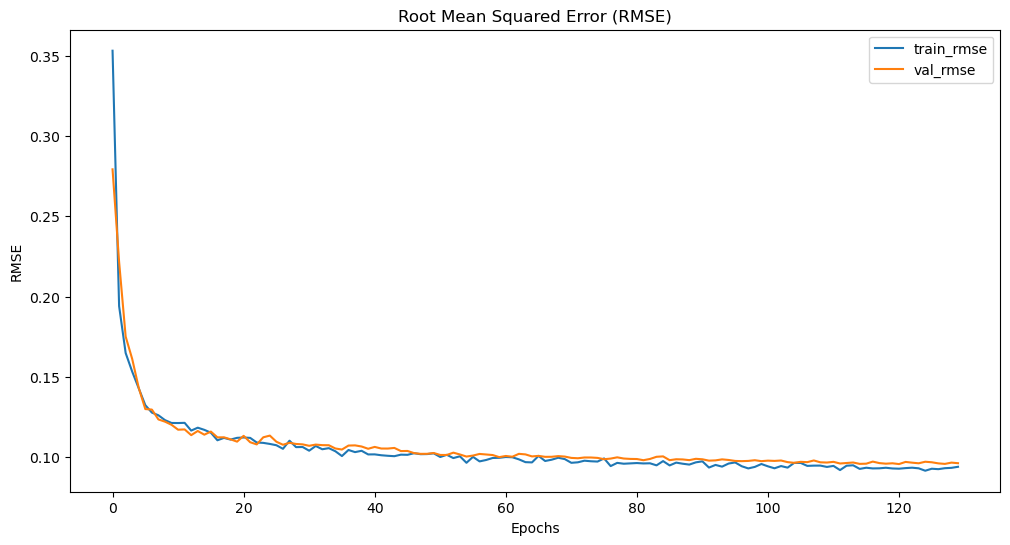

In [61]:
# Plot history for loss, MAE, and RMSE as before
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='train_mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('Mean Absolute Error (MAE)')
plt.show()

train_rmse = np.sqrt(history.history['mse'])
val_rmse = np.sqrt(history.history['val_mse'])
plt.figure(figsize=(12, 6))
plt.plot(train_rmse, label='train_rmse')
plt.plot(val_rmse, label='val_rmse')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.title('Root Mean Squared Error (RMSE)')
plt.show()

In [62]:
# Calculate MAPE manually, handling zero values
def safe_mape(y_true, y_pred, epsilon=1e-10):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / (y_true[mask] + epsilon))) * 100

train_predictions = model.predict(train_X)
train_X_reshaped = train_X.reshape((train_X.shape[0], train_X.shape[2]))
# Invert scaling for forecast
inv_yhat = np.concatenate((train_X_reshaped,train_predictions), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, -1]
# Invert scaling for actual
train_y_reshaped = train_y.reshape((len(train_y), 1))
inv_y = np.concatenate((train_X_reshaped, train_y_reshaped), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, -1]
# Calculate RMSE, MAE, MAPE
train_rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
train_mae = mean_absolute_error(inv_y, inv_yhat)
train_mape = np.mean(np.abs((inv_y - inv_yhat) / inv_y)) * 100


test_predictions = model.predict(test_X)
# Reshape test_X for inverse scaling
test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# Invert scaling for forecast
inv_yhat = np.concatenate((test_X_reshaped,test_predictions), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, -1]
# Invert scaling for actual
test_y_reshaped = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_X_reshaped, test_y_reshaped), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, -1]
# Calculate RMSE, MAE, MAPE
test_rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
test_mae = mean_absolute_error(inv_y, inv_yhat)
test_mape = np.mean(np.abs((inv_y - inv_yhat) / inv_y)) * 100


print(f"Train RMSE: {train_rmse:.3f}")
print(f"Train MAE: {train_mae:.3f}")
print(f"Train MAPE: {train_mape:.3f}%")
print(f"\nTest RMSE: {test_rmse:.3f}")
print(f"Test MAE: {test_mae:.3f}")
print(f"Test MAPE: {test_mape:.3f}%")

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step
Train RMSE: 1.293
Train MAE: 0.998
Train MAPE: 4.426%

Test RMSE: 1.390
Test MAE: 1.131
Test MAPE: 5.557%


## 1.6. prediction plot

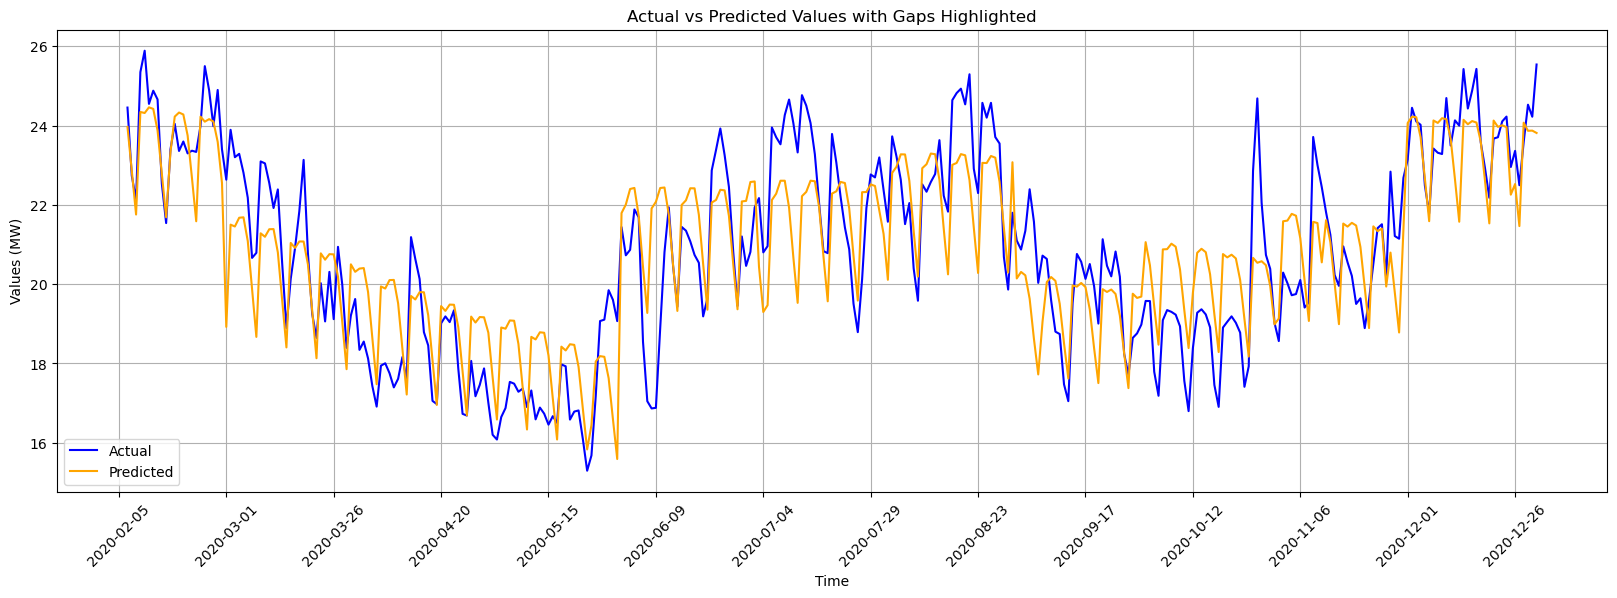

Gaps in data:


In [63]:
# Extract the test data with timestamps
test_df = daily_gross_load.iloc[train_days:, :].copy()
test_df['date'] = daily_gross_load.iloc[train_days:]['date']

# Identify gaps in the data
actual_vs_predicted = pd.DataFrame({
    'date': test_timestamps,
    'actual': inv_y,
    'predicted': inv_yhat
})

# Check for gaps in the timestamps (in days)
actual_vs_predicted['date_diff'] = actual_vs_predicted['date'].diff().dt.days
gaps = actual_vs_predicted[actual_vs_predicted['date_diff'] > 1]

# Plot actual vs predicted values with gaps highlighted
plt.figure(figsize=(20, 6))
plt.plot(actual_vs_predicted['date'], actual_vs_predicted['actual'], label='Actual', color='blue')
plt.plot(actual_vs_predicted['date'], actual_vs_predicted['predicted'], label='Predicted', color='orange')
for gap_start in gaps['date']:
    plt.axvline(x=gap_start, color='red', linestyle='--', alpha=0.5)
plt.title('Actual vs Predicted Values with Gaps Highlighted')
plt.xlabel('Time')
plt.ylabel('Values (MW)')
plt.legend()
plt.grid(True)

# Set date format on x-axis every 15 days
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=25))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)
plt.show()

# Print the gaps and their nearest significant time differences
print("Gaps in data:")
for index, row in gaps.iterrows():
    previous_timestamp = row['date'] - pd.Timedelta(days=row['date_diff'])
    next_timestamp = row['date'] + pd.Timedelta(days=row['date_diff'])

    previous_row = actual_vs_predicted[actual_vs_predicted['date'] == previous_timestamp]
    next_row = actual_vs_predicted[actual_vs_predicted['date'] == next_timestamp]

    gap_start = previous_row['date'].values[0] if not previous_row.empty else 'N/A'
    gap_end = row['date']

    print(f"Gap Start: {pd.to_datetime(gap_start).strftime('%Y-%m-%d') if gap_start != 'N/A' else 'N/A'}")
    print(f"Gap ends at: {gap_end.strftime('%Y-%m-%d')}")
    print(f"Time Difference: {row['date_diff']} days\n")

# 2. sumup model

## 2.1. load data

In [97]:
df = pd.read_csv('data\Gallup Historical Hourly Load-2018-2020.csv')
df

,Year,Month,Day,period,Total Gross Load,BTM WAPA,Total Net Load Serve,Unnamed: 7,Unnamed: 8,Unnamed: 9,Source,Unnamed: 11
0,2018,1,1,1,23.86,2.34,22,NaN,NaN,Total Gross Load,Gallup Historical,NaN
1,2018,1,1,2,23.46,2.34,21,NaN,NaN,BTM WAPA,Hourly estimated based on monthly/annual energy,NaN
2,2018,1,1,3,23.28,2.34,21,NaN,NaN,NaN,NaN,NaN
3,2018,1,1,4,23.07,2.34,21,NaN,NaN,Current PLEXOS Forecast Gross Flat,191,GWh/year
4,2018,1,1,5,23.44,2.34,21,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
26299,2020,12,31,20,28.39,2.34,26,NaN,NaN,NaN,NaN,NaN
26300,2020,12,31,21,27.43,2.34,25,NaN,NaN,NaN,NaN,NaN
26301,2020,12,31,22,26.25,2.34,24,NaN,NaN,NaN,NaN,NaN
26302,2020,12,31,23,25.18,2.34,23,NaN,NaN,NaN,NaN,NaN


In [98]:
df.columns

Index(['Year', 'Month ', 'Day', 'period', 'Total Gross Load', 'BTM WAPA',
       'Total Net Load Serve', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9',
       'Source', 'Unnamed: 11'],
      dtype='object')

In [99]:
df.rename(columns={'Year':'year', 'Month ':'month', 'Day':'day', 'period':'time', 'Total Gross Load':'gross_load'}, inplace=True)
df.drop(columns=['BTM WAPA','Total Net Load Serve', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9','Source', 'Unnamed: 11'], inplace=True)

In [100]:
df

,year,month,day,time,gross_load
0,2018,1,1,1,23.86
1,2018,1,1,2,23.46
2,2018,1,1,3,23.28
3,2018,1,1,4,23.07
4,2018,1,1,5,23.44
...,...,...,...,...,...
26299,2020,12,31,20,28.39
26300,2020,12,31,21,27.43
26301,2020,12,31,22,26.25
26302,2020,12,31,23,25.18


In [101]:
def time_convert(period):
    hour = (period - 1) % 24  # Convert period to 0-23 hour range
    return f'{hour:02d}:00:00'
# Create datetime column
df['hour_begins'] = pd.to_datetime(df[['year', 'month', 'day']].astype(str).agg('-'.join, axis=1) + ' ' + df['time'].apply(time_convert))

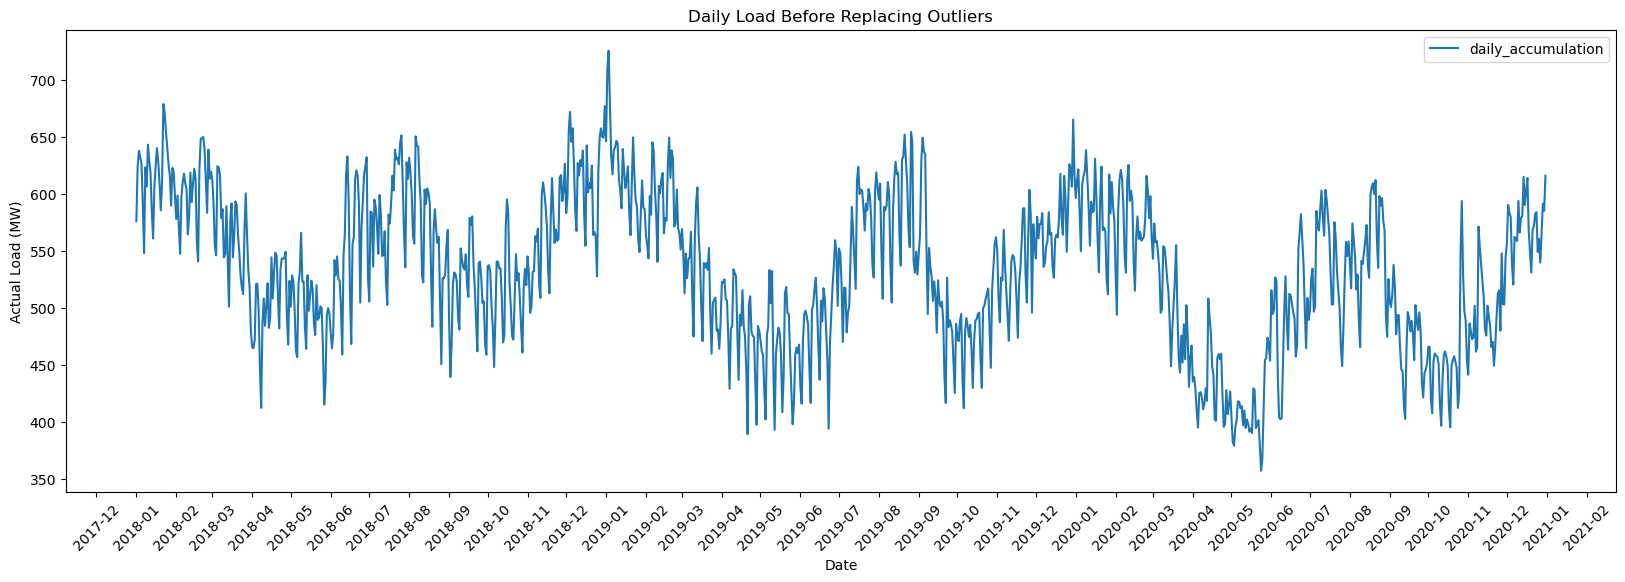

In [102]:
# calculate the daily accumulation of the load (gross_load_replaced)
df['date_begins'] = df['hour_begins'].dt.date
daily_accumulation_ = df.groupby('date_begins')['gross_load'].sum().reset_index()
daily_accumulation_.rename(columns = {'gross_load': 'daily_accumulation'}, inplace = True)
daily_accumulation_

import matplotlib.dates as mdates
# plot the daily average, min, max, std
plt.figure(figsize=(20, 6))
plt.plot(daily_accumulation_['date_begins'], daily_accumulation_['daily_accumulation'], label='daily_accumulation')
plt.xlabel('Date')
plt.ylabel('Actual Load (MW)')
plt.title('Daily Load Before Replacing Outliers')
plt.legend()

# Set date format on x-axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # set to show every 3 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)
plt.show()

In [103]:

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

# Apply the season function to the DataFrame
df['season'] = df['month'].apply(get_season)

Winter - Lower bound: 17.79, Upper bound: 31.45
Number of outliers in Winter: 3648

Spring - Lower bound: 13.02, Upper bound: 27.22
Number of outliers in Spring: 3241

Summer - Lower bound: 14.43, Upper bound: 33.43
Number of outliers in Summer: 526

Fall - Lower bound: 14.07, Upper bound: 29.61
Number of outliers in Fall: 1352



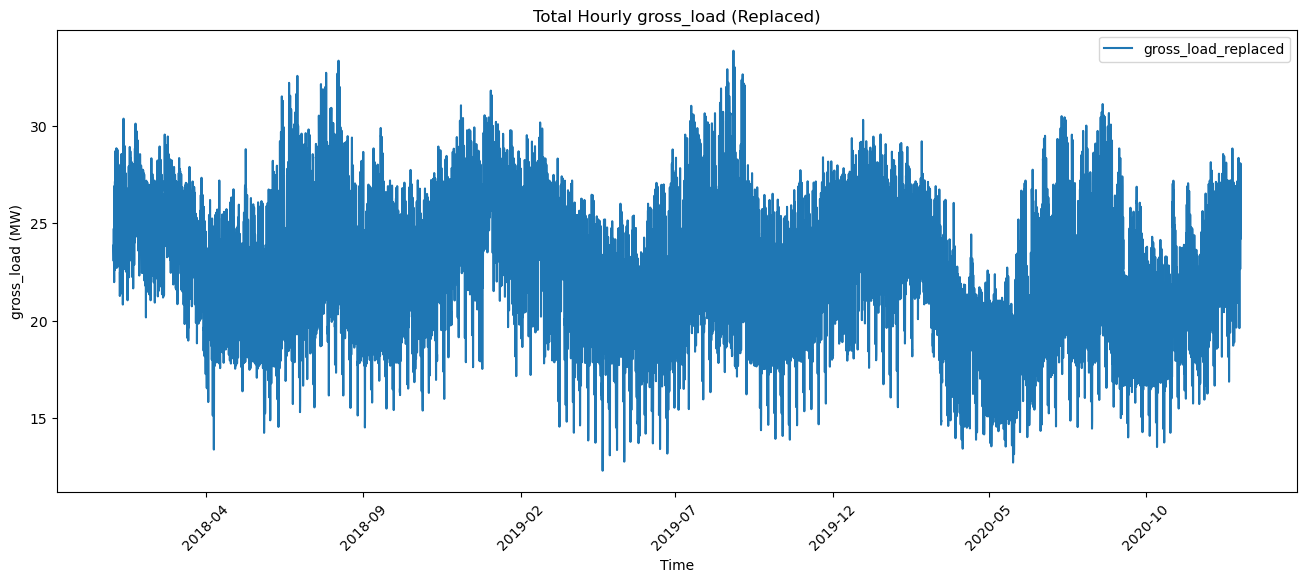

In [104]:
# Function to replace outliers within each season
def replace_outliers_with_avg_seasonal(df):
    df['gross_load_replaced'] = df['gross_load']
    for season in df['season'].unique():
        season_data = df[df['season'] == season]['gross_load']
        lower_bound = season_data.quantile(0.01)
        upper_bound = season_data.quantile(0.99)
        print(f'{season} - Lower bound: {lower_bound:.2f}, Upper bound: {upper_bound:.2f}')
        
        outliers = (df['gross_load'] < lower_bound) | (df['gross_load'] > upper_bound) | (df['gross_load'] == 0) | (df['gross_load'] == np.nan) 
        print(f'Number of outliers in {season}: {outliers.sum()}\n')
        # Remove continuous zeros or NaNs at the end
        while pd.isna(df.iloc[-1]['gross_load_replaced']) or df.iloc[-1]['gross_load_replaced'] == 0:
            df = df.iloc[:-1]

        for idx in df[outliers].index:
            if idx == 0 or idx == len(df) - 1:
                # directly drop the first and last value
                df.at[idx, 'gross_load_replaced'] = np.nan
                continue
            # Handle edge cases where previous or next value might be NaN or zero
            prev_idx = idx - 1
            next_idx = idx + 1
            while prev_idx >= 0 and (pd.isna(df.iloc[prev_idx]['gross_load_replaced']) or df.iloc[prev_idx]['gross_load_replaced'] == 0):
                prev_idx -= 1
            while next_idx < len(df) and (pd.isna(df.iloc[next_idx]['gross_load_replaced']) or df.iloc[next_idx]['gross_load_replaced'] == 0):
                next_idx += 1
            
            if prev_idx >= 0 and next_idx < len(df):
                prev_val = df.iloc[prev_idx]['gross_load_replaced']
                next_val = df.iloc[next_idx]['gross_load_replaced']
                df.at[idx, 'gross_load_replaced'] = (prev_val + next_val) / 2
            elif prev_idx >= 0:
                df.at[idx, 'gross_load_replaced'] = df.iloc[prev_idx]['gross_load_replaced']
            elif next_idx < len(df):
                df.at[idx, 'gross_load_replaced'] = df.iloc[next_idx]['gross_load_replaced']

    return df

df = replace_outliers_with_avg_seasonal(df)

plt.figure(figsize=(16, 6))
plt.plot(df['hour_begins'], df['gross_load_replaced'], label='gross_load_replaced')
plt.xlabel('Time')
plt.ylabel('gross_load (MW)')
plt.title('Total Hourly gross_load (Replaced)')
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

plt.show()

In [105]:
# Count the number of hours per day
df['date_begins'] = df['hour_begins'].dt.date
count_per_day = df.groupby('date_begins').size().reset_index(name='counts')

# Filter dates with less than 24 hours of data
incomplete_days = count_per_day[count_per_day['counts'] < 24]['date_begins']
print(f'Length of incomplete days: {len(incomplete_days)}')
print("Incomplete days (less than 24 hours of data):")
for day in incomplete_days:
    print(day)
# Remove rows with incomplete days
df_filtered = df[~df['date_begins'].isin(incomplete_days)]
df_filtered

Length of incomplete days: 3
Incomplete days (less than 24 hours of data):
2018-03-14
2019-03-14
2020-03-13


,year,month,day,time,gross_load,hour_begins,date_begins,season,gross_load_replaced
0,2018,1,1,1,23.86,2018-01-01 00:00:00,2018-01-01,Winter,23.86
1,2018,1,1,2,23.46,2018-01-01 01:00:00,2018-01-01,Winter,23.46
2,2018,1,1,3,23.28,2018-01-01 02:00:00,2018-01-01,Winter,23.28
3,2018,1,1,4,23.07,2018-01-01 03:00:00,2018-01-01,Winter,23.07
4,2018,1,1,5,23.44,2018-01-01 04:00:00,2018-01-01,Winter,23.44
...,...,...,...,...,...,...,...,...,...
26299,2020,12,31,20,28.39,2020-12-31 19:00:00,2020-12-31,Winter,27.75
26300,2020,12,31,21,27.43,2020-12-31 20:00:00,2020-12-31,Winter,27.00
26301,2020,12,31,22,26.25,2020-12-31 21:00:00,2020-12-31,Winter,26.25
26302,2020,12,31,23,25.18,2020-12-31 22:00:00,2020-12-31,Winter,25.18


In [106]:
df_filtered = df_filtered.dropna()
# calculate the daily accumulation of the load (gross_load_replaced)
daily_accumulation = df_filtered.groupby('date_begins')['gross_load_replaced'].sum().reset_index()
daily_accumulation.rename(columns = {'gross_load_replaced': 'daily_accumulation'}, inplace = True)
daily_accumulation

,date_begins,daily_accumulation
0,2018-01-01,574.341250
1,2018-01-02,620.036562
2,2018-01-03,631.495625
3,2018-01-04,627.024375
4,2018-01-05,624.305625
...,...,...
1088,2020-12-27,539.900000
1089,2020-12-28,566.045000
1090,2020-12-29,588.632500
1091,2020-12-30,581.355000


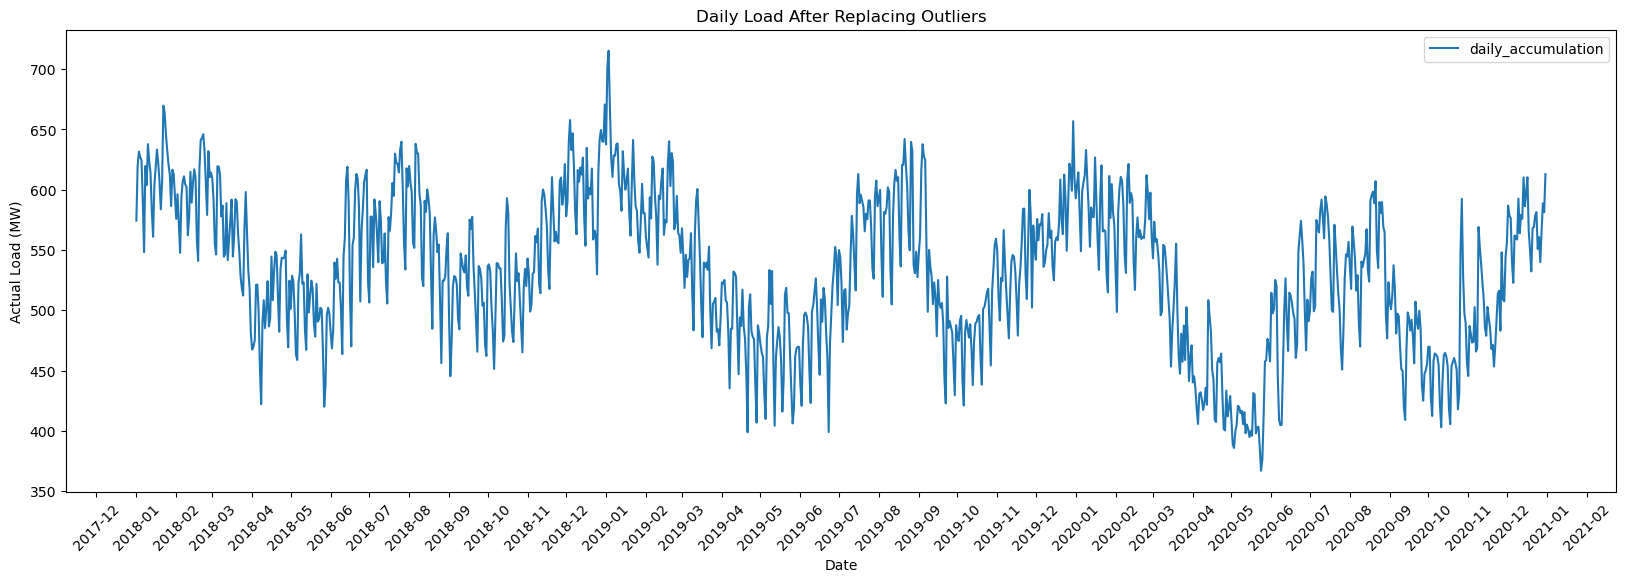

In [107]:
import matplotlib.dates as mdates
# plot the daily average, min, max, std
plt.figure(figsize=(20, 6))
plt.plot(daily_accumulation['date_begins'], daily_accumulation['daily_accumulation'], label='daily_accumulation')
plt.xlabel('Date')
plt.ylabel('Actual Load (MW)')
plt.title('Daily Load After Replacing Outliers')
plt.legend()

# Set date format on x-axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # set to show every 3 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)
plt.show()

## 2.2. feature engineering

In [108]:
# day of the week, month, year, season vairables
daily_accumulation['date_begins'] = pd.to_datetime(daily_accumulation['date_begins'])
daily_accumulation['day'] = daily_accumulation['date_begins'].dt.day
daily_accumulation['day_of_week'] = daily_accumulation['date_begins'].dt.dayofweek
daily_accumulation['month'] = daily_accumulation['date_begins'].dt.month
daily_accumulation['year'] = daily_accumulation['date_begins'].dt.year
daily_accumulation['seasons'] = (daily_accumulation['month']%12 + 3)//3
seasons = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
daily_accumulation['seasons'] = daily_accumulation['seasons'].map(seasons)

In [78]:
daily_accumulation['month_sin'] = np.sin((daily_accumulation['month'] - 1) * (2. * np.pi / 12))
daily_accumulation['month_cos'] = np.cos((daily_accumulation['month'] - 1) * (2. * np.pi / 12))
daily_accumulation['dow_sin'] = np.sin(daily_accumulation['day_of_week'] * (2. * np.pi / 7))
daily_accumulation['dow_cos'] = np.cos(daily_accumulation['day_of_week'] * (2. * np.pi / 7))

In [79]:
# holiday - 0/1 binary
us_holidays = holidays.US()
daily_accumulation['holiday'] = daily_accumulation['date_begins'].apply(lambda x: 1 if x in us_holidays else 0)

In [80]:
daily_accumulation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093 entries, 0 to 1092
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date_begins         1093 non-null   datetime64[ns]
 1   daily_accumulation  1093 non-null   float64       
 2   day                 1093 non-null   int32         
 3   day_of_week         1093 non-null   int32         
 4   month               1093 non-null   int32         
 5   year                1093 non-null   int32         
 6   seasons             1093 non-null   object        
 7   month_sin           1093 non-null   float64       
 8   month_cos           1093 non-null   float64       
 9   dow_sin             1093 non-null   float64       
 10  dow_cos             1093 non-null   float64       
 11  holiday             1093 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int32(4), int64(1), object(1)
memory usage: 85.5+ KB


In [81]:
daily_accumulation

,date_begins,daily_accumulation,day,day_of_week,month,year,seasons,month_sin,month_cos,dow_sin,dow_cos,holiday
0,2018-01-01,574.341250,1,0,1,2018,Winter,0.0,1.000000,0.000000,1.000000,1
1,2018-01-02,620.036562,2,1,1,2018,Winter,0.0,1.000000,0.781831,0.623490,0
2,2018-01-03,631.495625,3,2,1,2018,Winter,0.0,1.000000,0.974928,-0.222521,0
3,2018-01-04,627.024375,4,3,1,2018,Winter,0.0,1.000000,0.433884,-0.900969,0
4,2018-01-05,624.305625,5,4,1,2018,Winter,0.0,1.000000,-0.433884,-0.900969,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1088,2020-12-27,539.900000,27,6,12,2020,Winter,-0.5,0.866025,-0.781831,0.623490,0
1089,2020-12-28,566.045000,28,0,12,2020,Winter,-0.5,0.866025,0.000000,1.000000,0
1090,2020-12-29,588.632500,29,1,12,2020,Winter,-0.5,0.866025,0.781831,0.623490,0
1091,2020-12-30,581.355000,30,2,12,2020,Winter,-0.5,0.866025,0.974928,-0.222521,0


In [82]:
# print out the numerical and categorical features
numerical_features = daily_accumulation.select_dtypes(include=['float64']).columns.tolist()
categorical_features = daily_accumulation.select_dtypes(include=['datetime64[ns]', 'object', 'bool','int32','int64']).columns.tolist()
target = 'daily_accumulation'
numerical_features.remove(target)
print(f'Target variable: {target}')
print(f'Numerical features: {numerical_features}')
print(f'Categorical features: {categorical_features}')

# put categorical features first, numerical features last
daily_accumulation = daily_accumulation[categorical_features + numerical_features + [target]]
daily_accumulation

Target variable: daily_accumulation
Numerical features: ['month_sin', 'month_cos', 'dow_sin', 'dow_cos']
Categorical features: ['date_begins', 'day', 'day_of_week', 'month', 'year', 'seasons', 'holiday']


,date_begins,day,day_of_week,month,year,seasons,holiday,month_sin,month_cos,dow_sin,dow_cos,daily_accumulation
0,2018-01-01,1,0,1,2018,Winter,1,0.0,1.000000,0.000000,1.000000,574.341250
1,2018-01-02,2,1,1,2018,Winter,0,0.0,1.000000,0.781831,0.623490,620.036562
2,2018-01-03,3,2,1,2018,Winter,0,0.0,1.000000,0.974928,-0.222521,631.495625
3,2018-01-04,4,3,1,2018,Winter,0,0.0,1.000000,0.433884,-0.900969,627.024375
4,2018-01-05,5,4,1,2018,Winter,0,0.0,1.000000,-0.433884,-0.900969,624.305625
...,...,...,...,...,...,...,...,...,...,...,...,...
1088,2020-12-27,27,6,12,2020,Winter,0,-0.5,0.866025,-0.781831,0.623490,539.900000
1089,2020-12-28,28,0,12,2020,Winter,0,-0.5,0.866025,0.000000,1.000000,566.045000
1090,2020-12-29,29,1,12,2020,Winter,0,-0.5,0.866025,0.781831,0.623490,588.632500
1091,2020-12-30,30,2,12,2020,Winter,0,-0.5,0.866025,0.974928,-0.222521,581.355000


In [83]:
daily_accumulation.columns

Index(['date_begins', 'day', 'day_of_week', 'month', 'year', 'seasons',
       'holiday', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos',
       'daily_accumulation'],
      dtype='object')

##  2.3. scaling and encoding

In [84]:
# encoding the categorical features - season only at the second column of values
daily_accumulation = pd.get_dummies(daily_accumulation, columns=['seasons'], drop_first=True) # at the last 3 columns
# Convert boolean columns to integers
for col in daily_accumulation.columns:
    if daily_accumulation[col].dtype == 'bool':
        daily_accumulation[col] = daily_accumulation[col].astype(int)
# place the target variable at the last column
daily_accumulation = daily_accumulation[[c for c in daily_accumulation if c not in ['daily_accumulation']] + ['daily_accumulation']]

In [85]:
# scaling the columns except for the 1 column
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
daily_accumulation.iloc[:, 1:] = scaler.fit_transform(daily_accumulation.iloc[:, 1:])
daily_accumulation

,date_begins,day,day_of_week,month,year,holiday,month_sin,month_cos,dow_sin,dow_cos,seasons_Spring,seasons_Summer,seasons_Winter,daily_accumulation
0,2018-01-01,0.000000,0.000000,0.0,0.0,1,0.50,1.000000,0.500000,1.000000e+00,0,0,1,0.595353
1,2018-01-02,0.033333,0.166667,0.0,0.0,0,0.50,1.000000,0.900969,8.019377e-01,0,0,1,0.726619
2,2018-01-03,0.066667,0.333333,0.0,0.0,0,0.50,1.000000,1.000000,3.568959e-01,0,0,1,0.759537
3,2018-01-04,0.100000,0.500000,0.0,0.0,0,0.50,1.000000,0.722521,5.551115e-17,0,0,1,0.746693
4,2018-01-05,0.133333,0.666667,0.0,0.0,0,0.50,1.000000,0.277479,0.000000e+00,0,0,1,0.738883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1088,2020-12-27,0.866667,1.000000,1.0,1.0,0,0.25,0.933013,0.099031,8.019377e-01,0,0,1,0.496415
1089,2020-12-28,0.900000,0.000000,1.0,1.0,0,0.25,0.933013,0.500000,1.000000e+00,0,0,1,0.571520
1090,2020-12-29,0.933333,0.166667,1.0,1.0,0,0.25,0.933013,0.900969,8.019377e-01,0,0,1,0.636406
1091,2020-12-30,0.966667,0.333333,1.0,1.0,0,0.25,0.933013,1.000000,3.568959e-01,0,0,1,0.615501


In [86]:
# save the values of column gross_load_replaced, drop it and the attach at the last column 
gross_load_replaced = daily_accumulation['daily_accumulation']
daily_accumulation.drop(columns='daily_accumulation', inplace=True)
daily_accumulation['daily_accumulation'] = gross_load_replaced
daily_accumulation

,date_begins,day,day_of_week,month,year,holiday,month_sin,month_cos,dow_sin,dow_cos,seasons_Spring,seasons_Summer,seasons_Winter,daily_accumulation
0,2018-01-01,0.000000,0.000000,0.0,0.0,1,0.50,1.000000,0.500000,1.000000e+00,0,0,1,0.595353
1,2018-01-02,0.033333,0.166667,0.0,0.0,0,0.50,1.000000,0.900969,8.019377e-01,0,0,1,0.726619
2,2018-01-03,0.066667,0.333333,0.0,0.0,0,0.50,1.000000,1.000000,3.568959e-01,0,0,1,0.759537
3,2018-01-04,0.100000,0.500000,0.0,0.0,0,0.50,1.000000,0.722521,5.551115e-17,0,0,1,0.746693
4,2018-01-05,0.133333,0.666667,0.0,0.0,0,0.50,1.000000,0.277479,0.000000e+00,0,0,1,0.738883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1088,2020-12-27,0.866667,1.000000,1.0,1.0,0,0.25,0.933013,0.099031,8.019377e-01,0,0,1,0.496415
1089,2020-12-28,0.900000,0.000000,1.0,1.0,0,0.25,0.933013,0.500000,1.000000e+00,0,0,1,0.571520
1090,2020-12-29,0.933333,0.166667,1.0,1.0,0,0.25,0.933013,0.900969,8.019377e-01,0,0,1,0.636406
1091,2020-12-30,0.966667,0.333333,1.0,1.0,0,0.25,0.933013,1.000000,3.568959e-01,0,0,1,0.615501


In [87]:
daily_accumulation = daily_accumulation.dropna()
daily_accumulation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093 entries, 0 to 1092
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date_begins         1093 non-null   datetime64[ns]
 1   day                 1093 non-null   float64       
 2   day_of_week         1093 non-null   float64       
 3   month               1093 non-null   float64       
 4   year                1093 non-null   float64       
 5   holiday             1093 non-null   int64         
 6   month_sin           1093 non-null   float64       
 7   month_cos           1093 non-null   float64       
 8   dow_sin             1093 non-null   float64       
 9   dow_cos             1093 non-null   float64       
 10  seasons_Spring      1093 non-null   int32         
 11  seasons_Summer      1093 non-null   int32         
 12  seasons_Winter      1093 non-null   int32         
 13  daily_accumulation  1093 non-null   float64     

## 2.4. dividing the data into training and testing

In [88]:
years_of_data = len(daily_accumulation) / 365
print(f'Total years of data: {years_of_data}')
# total number of days for training and testing
print(f'Total number of days for training: {daily_accumulation.shape[0]}')

Total years of data: 2.9945205479452053
Total number of days for training: 1093


In [89]:
daily_accumulation = daily_accumulation.sort_values(by='date_begins')
values = daily_accumulation.drop(columns='date_begins').values
dates = daily_accumulation['date_begins']

# out of sample data: total length multiplies 0.3
train_days = int(values.shape[0] * 0.7)
# in sample data: the rest of the data
train = values[:train_days, :]
train_timestamps = dates[:train_days]
# print(f'start date of in sample data: {train["date"].min()}')
# print(f'end date of in sample data: {train["date"].max()}')
# print(f'length of in sample data: {train.
# shape[0]}\n')

print(f'min: {train_timestamps.min()}')
print(f'max: {train_timestamps.max()}')
print(f'length of in sample data: {train.shape[0]}\n')

test = values[train_days:, : ]
test_timestamps = dates[train_days:]
# print(f'start date of out of sample data: {test["date"].min()}')
# print(f'end date of out of sample data: {test["date"].max()}')
# print(f'length of out of sample data: {test.shape[0]}\n')

print(f'min: {test_timestamps.min()}')
print(f'max: {test_timestamps.max()}')
print(f'length of out of sample data: {test.shape[0]}')

min: 2018-01-01 00:00:00
max: 2020-02-06 00:00:00
length of in sample data: 765

min: 2020-02-07 00:00:00
max: 2020-12-31 00:00:00
length of out of sample data: 328


In [90]:
# dividing the data into x and y
# x: All columns except the last,  y: The last column
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(765, 1, 12) (765,) (328, 1, 12) (328,)


## 2.5. fitting the model

In [91]:
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.35))
model.add(Dense(1, kernel_regularizer=l2(0.001)))

# Set the initial learning rate to a lower value
initial_learning_rate = 0.005
optimizer = Adam(learning_rate=initial_learning_rate)
model.compile(loss='mae', optimizer=optimizer, metrics=['mae', 'mse', 'mape'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

# Fit the network
history = model.fit(train_X, train_y, epochs=200, batch_size=64, validation_data=(test_X, test_y),
                    verbose=2, shuffle=False,callbacks=[early_stopping, reduce_lr])

Epoch 1/200
12/12 - 1s - 72ms/step - loss: 0.2949 - mae: 0.2930 - mape: 58.0385 - mse: 0.1296 - val_loss: 0.2167 - val_mae: 0.2147 - val_mape: 2019242.5000 - val_mse: 0.0708 - learning_rate: 0.0050
Epoch 2/200
12/12 - 0s - 3ms/step - loss: 0.1598 - mae: 0.1580 - mape: 40.9609 - mse: 0.0390 - val_loss: 0.1287 - val_mae: 0.1270 - val_mape: 1237226.5000 - val_mse: 0.0237 - learning_rate: 0.0050
Epoch 3/200
12/12 - 0s - 3ms/step - loss: 0.1323 - mae: 0.1306 - mape: 29.0650 - mse: 0.0266 - val_loss: 0.1288 - val_mae: 0.1272 - val_mape: 1223539.7500 - val_mse: 0.0245 - learning_rate: 0.0050
Epoch 4/200
12/12 - 0s - 3ms/step - loss: 0.1178 - mae: 0.1161 - mape: 27.9626 - mse: 0.0209 - val_loss: 0.1068 - val_mae: 0.1052 - val_mape: 937232.1250 - val_mse: 0.0165 - learning_rate: 0.0050
Epoch 5/200
12/12 - 0s - 3ms/step - loss: 0.1106 - mae: 0.1090 - mape: 24.0794 - mse: 0.0186 - val_loss: 0.1081 - val_mae: 0.1064 - val_mape: 903006.3125 - val_mse: 0.0166 - learning_rate: 0.0050
Epoch 6/200
12/1

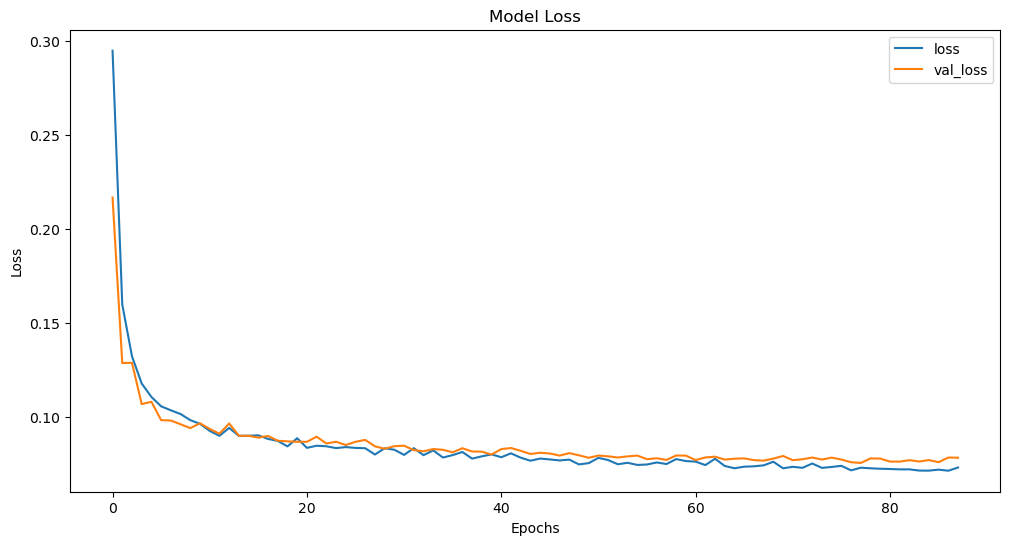

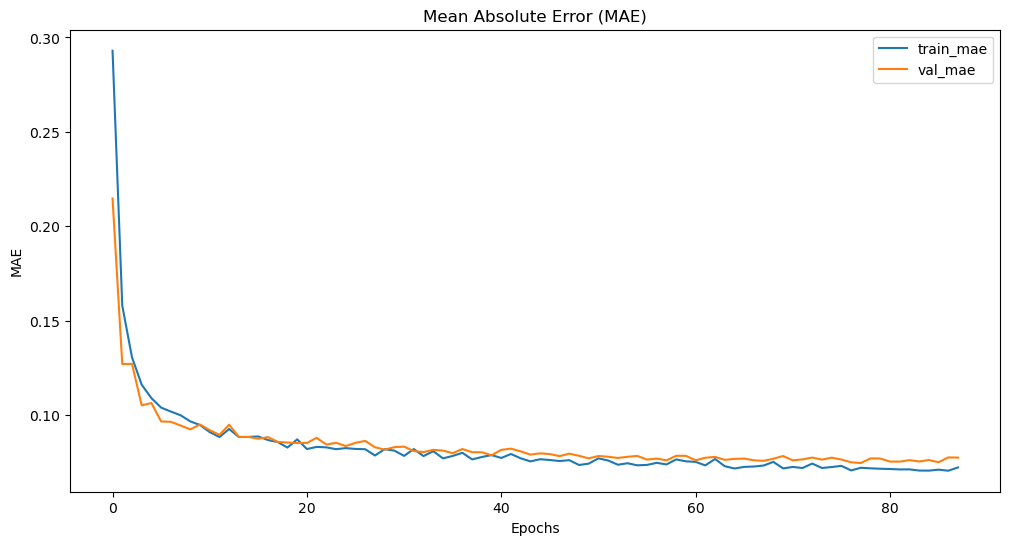

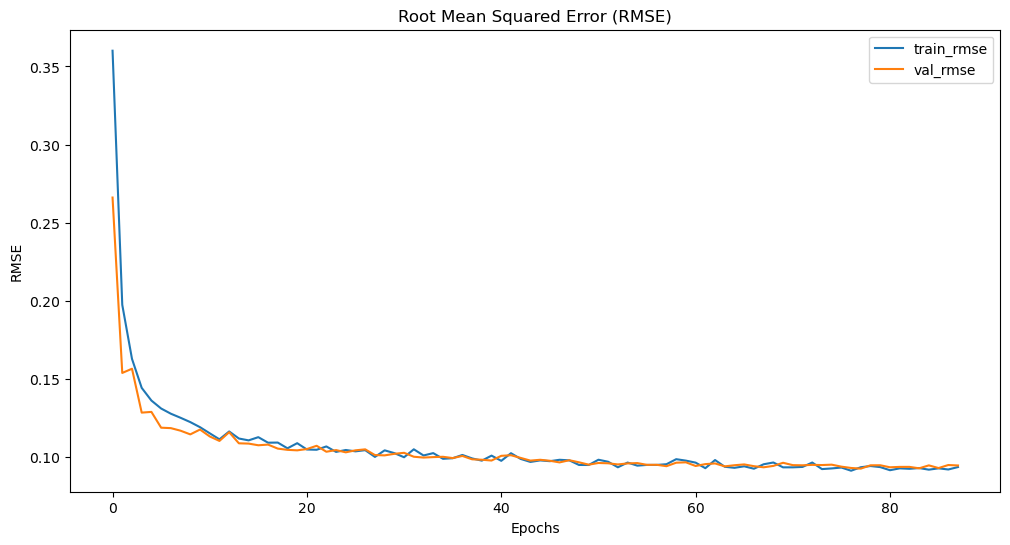

In [92]:
# Plot history for loss, MAE, and RMSE as before
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='train_mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('Mean Absolute Error (MAE)')
plt.show()

train_rmse = np.sqrt(history.history['mse'])
val_rmse = np.sqrt(history.history['val_mse'])
plt.figure(figsize=(12, 6))
plt.plot(train_rmse, label='train_rmse')
plt.plot(val_rmse, label='val_rmse')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.title('Root Mean Squared Error (RMSE)')
plt.show()

In [93]:
# Calculate MAPE manually, handling zero values
def safe_mape(y_true, y_pred, epsilon=1e-10):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / (y_true[mask] + epsilon))) * 100

train_predictions = model.predict(train_X)
train_X_reshaped = train_X.reshape((train_X.shape[0], train_X.shape[2]))
# Invert scaling for forecast
inv_yhat = np.concatenate((train_X_reshaped,train_predictions), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, -1]
# Invert scaling for actual
train_y_reshaped = train_y.reshape((len(train_y), 1))
inv_y = np.concatenate((train_X_reshaped, train_y_reshaped), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, -1]
# Calculate RMSE, MAE, MAPE
train_rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
train_mae = mean_absolute_error(inv_y, inv_yhat)
train_mape = np.mean(np.abs((inv_y - inv_yhat) / inv_y)) * 100


test_predictions = model.predict(test_X)
# Reshape test_X for inverse scaling
test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# Invert scaling for forecast
inv_yhat = np.concatenate((test_X_reshaped,test_predictions), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, -1]
# Invert scaling for actual
test_y_reshaped = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_X_reshaped, test_y_reshaped), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, -1]
# Calculate RMSE, MAE, MAPE
test_rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
test_mae = mean_absolute_error(inv_y, inv_yhat)
test_mape = np.mean(np.abs((inv_y - inv_yhat) / inv_y)) * 100


print(f"Train RMSE: {train_rmse:.3f}")
print(f"Train MAE: {train_mae:.3f}")
print(f"Train MAPE: {train_mape:.3f}%")
print(f"\nTest RMSE: {test_rmse:.3f}")
print(f"Test MAE: {test_mae:.3f}")
print(f"Test MAPE: {test_mape:.3f}%")

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step
Train RMSE: 30.653
Train MAE: 23.451
Train MAPE: 4.337%

Test RMSE: 32.285
Test MAE: 25.984
Test MAPE: 5.294%


## 2.6. prediction plot

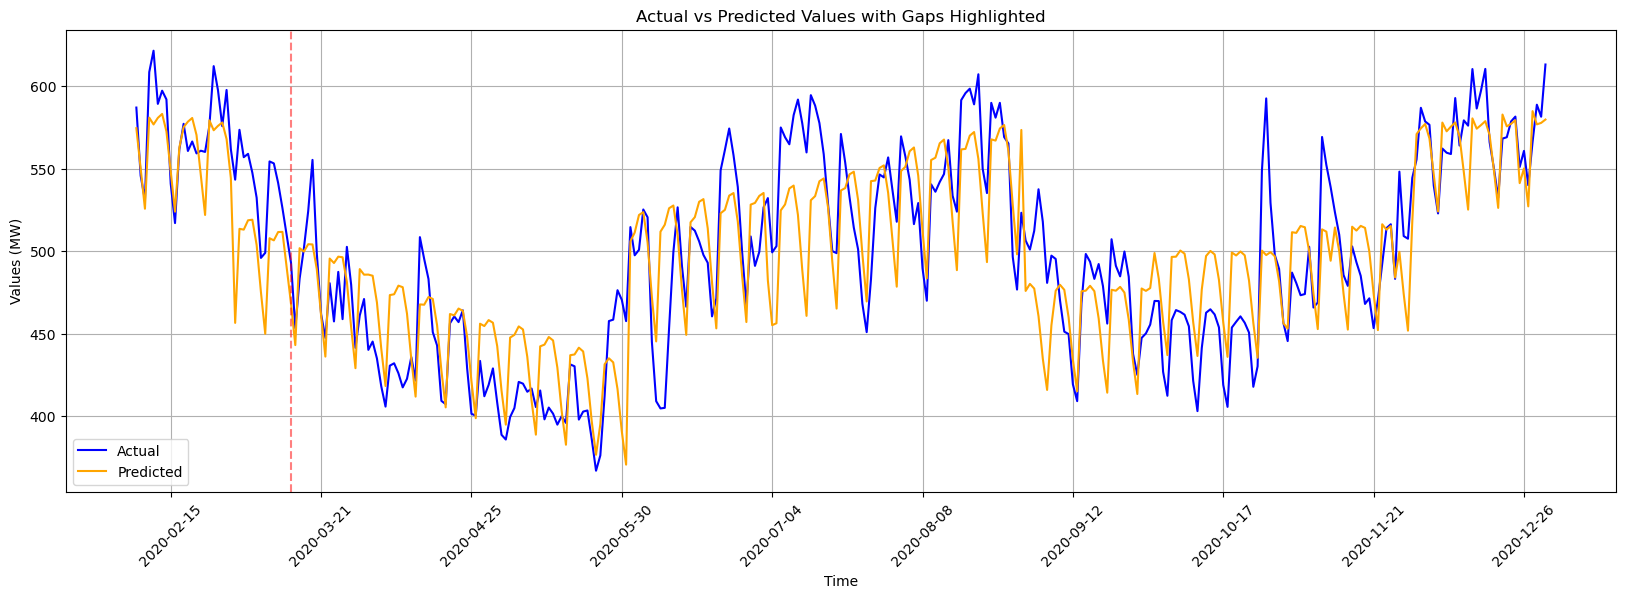

Gaps in data:
Gap Start: 2020-03-12
Gap ends at: 2020-03-14
Time Difference: 2.0 days



In [94]:
# Extract the test data with timestamps
test_df = daily_gross_load.iloc[train_days:, :].copy()
test_df['date'] = daily_gross_load.iloc[train_days:]['date']

# Identify gaps in the data
actual_vs_predicted = pd.DataFrame({
    'date': test_timestamps,
    'actual': inv_y,
    'predicted': inv_yhat
})

# Check for gaps in the timestamps (in days)
actual_vs_predicted['date_diff'] = actual_vs_predicted['date'].diff().dt.days
gaps = actual_vs_predicted[actual_vs_predicted['date_diff'] > 1]

# Plot actual vs predicted values with gaps highlighted
plt.figure(figsize=(20, 6))
plt.plot(actual_vs_predicted['date'], actual_vs_predicted['actual'], label='Actual', color='blue')
plt.plot(actual_vs_predicted['date'], actual_vs_predicted['predicted'], label='Predicted', color='orange')
for gap_start in gaps['date']:
    plt.axvline(x=gap_start, color='red', linestyle='--', alpha=0.5)
plt.title('Actual vs Predicted Values with Gaps Highlighted')
plt.xlabel('Time')
plt.ylabel('Values (MW)')
plt.legend()
plt.grid(True)

# Set date format on x-axis every 15 days
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=35))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)
plt.show()

# Print the gaps and their nearest significant time differences
print("Gaps in data:")
for index, row in gaps.iterrows():
    previous_timestamp = row['date'] - pd.Timedelta(days=row['date_diff'])
    next_timestamp = row['date'] + pd.Timedelta(days=row['date_diff'])

    previous_row = actual_vs_predicted[actual_vs_predicted['date'] == previous_timestamp]
    next_row = actual_vs_predicted[actual_vs_predicted['date'] == next_timestamp]

    gap_start = previous_row['date'].values[0] if not previous_row.empty else 'N/A'
    gap_end = row['date']

    print(f"Gap Start: {pd.to_datetime(gap_start).strftime('%Y-%m-%d') if gap_start != 'N/A' else 'N/A'}")
    print(f"Gap ends at: {gap_end.strftime('%Y-%m-%d')}")
    print(f"Time Difference: {row['date_diff']} days\n")